In [1]:
#IMPORT SEMUA PLUGIN

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from matplotlib import pyplot as plt
from matplotlib import style
import os
from fpdf import FPDF
import io
import base64
import xlsxwriter 

In [3]:
#FUNGSI UNTUK MENGUPLOAD DATA DARI CSV KE POSTGRESQL

In [4]:
def uploadToPSQL(columns, table, filePath, engine):
    df = pd.read_csv(
        os.path.abspath(filePath),
        names=columns,
        keep_default_na=False
    )
    df.fillna('')
    del df['kategori']
    del df['jenis']
    del df['pengiriman']
    del df['satuan']
    
    df.to_sql(
        table, 
        engine,
        if_exists='replace'
    )

    if len(df) == 0:
        return False
    else:
        return True

In [5]:
#FUNGSI UNTUK MEMBUAT CHART, DATA YANG DIAMBIL DARI DATABASE DENGAN MENGGUNAKAN ORDER DARI TANGGAL DAN JUGA LIMIT
#DISINI JUGA MEMANGGIL FUNGSI MAKEEXCEL DAN MAKEPDF

In [6]:
def makeChart(host, username, password, db, port, table, judul, columns, filePath, name, subjudul, limit, negara, basePath):
    try:
        connection = psycopg2.connect(user=username,password=password,host=host,port=port,database=db)
        cursor = connection.cursor()
        postgreSQL_select_Query = "SELECT * FROM "+table+" ORDER BY tanggal ASC LIMIT " + str(limit)
    
        cursor.execute(postgreSQL_select_Query)
        mobile_records = cursor.fetchall() 
        uid = []
        lengthx = []
        lengthy = []
        for row in mobile_records:
            uid.append(row[0])
            lengthx.append(row[1])
            if row[2] == "":
                lengthy.append(float(0))
            else:
                lengthy.append(float(row[2]))
        #bar
        style.use('ggplot')
   
        fig, ax = plt.subplots()
        ax.bar(uid, lengthy, align='center')
        ax.set_title(judul)
        ax.set_ylabel('Total')
        ax.set_xlabel('Tanggal')
    
        ax.set_xticks(uid)
        ax.set_xticklabels((lengthx))
        b = io.BytesIO()
        plt.savefig(b, format='png', bbox_inches="tight")
        
        barChart = base64.b64encode(b.getvalue()).decode("utf-8").replace("\n", "")
        plt.show()
        
        #line
        plt.plot(lengthx, lengthy)
        plt.xlabel('Tanggal')
        plt.ylabel('Total')
    
        plt.title(judul)
        plt.grid(True)
        l = io.BytesIO()
        plt.savefig(l, format='png', bbox_inches="tight")
        
        lineChart = base64.b64encode(l.getvalue()).decode("utf-8").replace("\n", "")
        plt.show()
        
        #pie
        plt.title(judul)
        plt.pie(lengthy, labels=lengthx, autopct='%1.1f%%', 
        shadow=True, startangle=180)
    
        plt.axis('equal')
        p = io.BytesIO()
        plt.savefig(p, format='png', bbox_inches="tight")
        
        pieChart = base64.b64encode(p.getvalue()).decode("utf-8").replace("\n", "")
        plt.show()
        
        row = pd.read_csv(
            os.path.abspath(filePath),
            names=columns,
            keep_default_na=False
        )
        row.fillna('')
        
        del row['kategori']
        del row['jenis']
        del row['pengiriman']
        del row['satuan']
        
        header = pd.read_csv(
            os.path.abspath(filePath),
            names=columns,
            keep_default_na=False
        )
        header.fillna('')
        del header['tanggal']
        del header['total']
        makeExcel(mobile_records, header, name, limit, basePath)
        makePDF(mobile_records, header, judul, barChart, lineChart, pieChart, name, subjudul, limit, basePath)        
        
    except (Exception, psycopg2.Error) as error :
        print (error)

    finally:
        if(connection):
            cursor.close()
            connection.close()

In [7]:
#FUNGSI MAKEEXCEL GUNANYA UNTUK MEMBUAT DATA YANG BERASAL DARI DATABASE DIJADIKAN FORMAT EXCEL TABLE F2
#PLUGIN YANG DIGUNAKAN ADALAH XLSXWRITER

In [8]:
def makeExcel(datarow, dataheader, name, limit, basePath):
    workbook = xlsxwriter.Workbook(basePath+'excel/'+name+'.xlsx')
    worksheet = workbook.add_worksheet('name')
    row1 = workbook.add_format({'border': 2, 'bold': 1})
    row2 = workbook.add_format({'border': 2})
    data=list(datarow)
    isihead=list(dataheader.values)
    header = []
    body = []
    
    for rowhead in dataheader:
        header.append(str(rowhead))
        
    for rowhead2 in datarow:
        header.append(str(rowhead2[1]))
        
    for rowbody in isihead[1]:
        body.append(str(rowbody))
        
    for rowbody2 in data:
        body.append(str(rowbody2[2]))
        
    for col_num, data in enumerate(header):
        worksheet.write(0, col_num, data, row1)
        
    for col_num, data in enumerate(body):
        worksheet.write(1, col_num, data, row2)
    
    workbook.close()

In [9]:
#FUNGSI UNTUK MEMBUAT PDF YANG DATANYA BERASAL DARI DATABASE DIJADIKAN FORMAT EXCEL TABLE F2
#PLUGIN YANG DIGUNAKAN ADALAH FPDF

In [10]:
def makePDF(datarow, dataheader, judul, bar, line, pie, name, subjudul, lengthPDF, basePath):
    pdf = FPDF('L', 'mm', [210,297])
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 20.0)
    pdf.set_xy(145.0, 15.0)
    pdf.cell(ln=0, h=2.0, align='C', w=10.0, txt=judul, border=0)
    
    pdf.set_font('arial', '', 14.0)
    pdf.set_xy(145.0, 25.0)
    pdf.cell(ln=0, h=2.0, align='C', w=10.0, txt=subjudul, border=0)
    pdf.line(10.0, 30.0, 287.0, 30.0)
    pdf.set_font('times', '', 10.0)
    pdf.set_xy(17.0, 37.0)
    
    pdf.set_font('Times','',10.0) 
    datahead=list(dataheader.values)
    pdf.set_font('Times','B',12.0) 
    pdf.ln(0.5)
    
    th1 = pdf.font_size
    
    pdf.cell(100, 2*th1, "Kategori", border=1, align='C')
    pdf.cell(177, 2*th1, datahead[0][0], border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Jenis", border=1, align='C')
    pdf.cell(177, 2*th1, datahead[0][1], border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Pengiriman", border=1, align='C')
    pdf.cell(177, 2*th1, datahead[0][2], border=1, align='C')
    pdf.ln(2*th1)
    pdf.cell(100, 2*th1, "Satuan", border=1, align='C')
    pdf.cell(177, 2*th1, datahead[0][3], border=1, align='C')
    pdf.ln(2*th1)
    
    pdf.set_xy(17.0, 75.0)
    
    pdf.set_font('Times','B',11.0) 
    data=list(datarow)
    epw = pdf.w - 2*pdf.l_margin
    col_width = epw/(lengthPDF+1)
    
    pdf.ln(0.5)
    th = pdf.font_size
    
    pdf.cell(50, 2*th, str("Negara"), border=1, align='C')
    for row in data:
        pdf.cell(40, 2*th, str(row[1]), border=1, align='C')
    pdf.ln(2*th)
    
    pdf.set_font('Times','B',10.0)
    pdf.set_font('Arial','',9)
    pdf.cell(50, 2*th, negara, border=1, align='C')
    for row in data:
        pdf.cell(40, 2*th, str(row[2]), border=1, align='C')
    pdf.ln(2*th)
    
    bardata = base64.b64decode(bar)
    barname = basePath+'img/'+name+'-bar.png'
    with open(barname, 'wb') as f:
        f.write(bardata)
    
    linedata = base64.b64decode(line)
    linename = basePath+'img/'+name+'-line.png'
    with open(linename, 'wb') as f:
        f.write(linedata)
        
    piedata = base64.b64decode(pie)
    piename = basePath+'img/'+name+'-pie.png'
    with open(piename, 'wb') as f:
        f.write(piedata)
    
    pdf.set_xy(17.0, 75.0)
    col = pdf.w - 2*pdf.l_margin
    widthcol = col/3
    pdf.image(barname, link='', type='',x=8, y=100, w=widthcol)
    pdf.set_xy(17.0, 75.0)
    col = pdf.w - 2*pdf.l_margin
    pdf.image(linename, link='', type='',x=103, y=100, w=widthcol)
    pdf.set_xy(17.0, 75.0)
    col = pdf.w - 2*pdf.l_margin
    pdf.image(piename, link='', type='',x=195, y=100, w=widthcol)
    pdf.ln(2*th)
    
    pdf.output(basePath+'pdf/'+name+'.pdf', 'F')

In [11]:
#DISINI TEMPAT AWAL UNTUK MENDEFINISIKAN VARIABEL VARIABEL SEBELUM NANTINYA DIKIRIM KE FUNGSI
#PERTAMA MANGGIL FUNGSI UPLOADTOPSQL DULU, KALAU SUKSES BARU MANGGIL FUNGSI MAKECHART
#DAN DI MAKECHART MANGGIL FUNGSI MAKEEXCEL DAN MAKEPDF

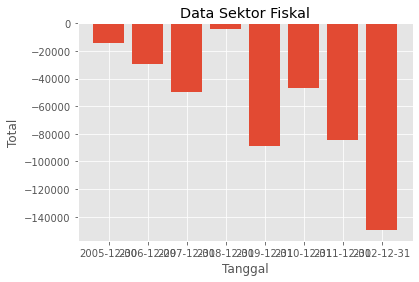

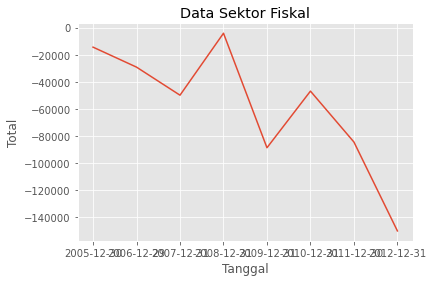

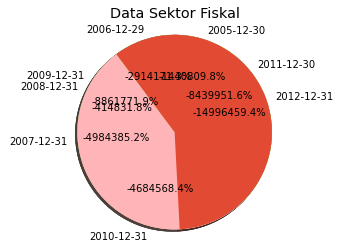

In [12]:
columns = [
    "kategori",
    "jenis",
    "tanggal",
    "total",
    "pengiriman",
    "satuan",
]

name = "SektorFiskal1_1"
host = "localhost"
username = "postgres"
password = "1234567890"
port = "5432"
database = "bloomberg_sektorfiskal"
table = name.lower()
judul = "Data Sektor Fiskal"
subjudul = "Badan Perencanaan Pembangunan Nasional"
limitdata = int(8)
negara = "Indonesia"
basePath = 'C:/Users/ASUS/Documents/bappenas/BLOOMBERG/SektorFiskal/'
filePath = basePath+ '' +name+'.csv';
engine = create_engine('postgresql://'+username+':'+password+'@'+host+':'+port+'/'+database)

checkUpload = uploadToPSQL(columns, table, filePath, engine)
if checkUpload == True:
    makeChart(host, username, password, database, port, table, judul, columns, filePath, name, subjudul, limitdata, negara, basePath)
else:
    print("Error When Upload CSV")